In [2]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy.stats
import pandas as pd
import mplhep as hep
from iminuit import cost, Minuit
# faster than scipy.stats functions
from numba_stats import truncnorm, truncexpon, norm, expon
from scipy.stats import multivariate_normal as mvnorm
# hep.style.use("CMS")

## Import and process files

In [2]:
N = 13500

    
filenames = ["Cf_14k_1220_2000.ecor"] 


variables=np.zeros((N,7))

dN = 0

for name in filenames:
    print(f"Opening {name}")
    df_temp = pd.read_csv(name, skiprows = lambda x: x % 2566 < 6, delimiter = ";" , names=["t1","A1","t2","A2", "t3", "A3","t4","A4"])
    # df_temp = pd.DataFrame(columns=["t1","A1","t2","A2", "t3", "A3","t4","A4"])
    
    deriv = df_temp.diff()

    df_temp["d1"] = deriv["A1"]/deriv["t1"]
    df_temp["d2"] = deriv["A2"]/deriv["t2"]
    df_temp["d3"] = deriv["A3"]/deriv["t3"]
    df_temp["d4"] = deriv["A4"]/deriv["t4"]
    
    print("Derivatives computed")
    
    
    n = int(np.ceil(len(df_temp)/2560))
    variables_temp=np.zeros((n,7))
    
    for i in range(n):
        
        df0 = df_temp[2560*i:2560*(i+1)]
        
        variables_temp[i,0] = df0.at[df0["d2"].idxmin(),"t2"] - df0.at[df0["d1"].idxmin(),"t1"]
        
        variables_temp[i,1] = -min(df0["A3"])
        variables_temp[i,2] = -min(df0["A4"])
        
        df1=df0.to_numpy()
        mins = np.argmin(df1,axis=0)
        IDminA3 = mins[5]
        IDminA4 = mins[7]
        
        offsetA3 = np.mean(df1[IDminA3-200:IDminA3-150,5])
        offsetA4 = np.mean(df1[IDminA4-200:IDminA4-150,7])
        
        start_int = -100
        end_int = 150
        
        intA3 = -np.sum(df1[IDminA3+start_int:IDminA3+end_int,5]-offsetA3)*0.5
        intA4 = -np.sum(df1[IDminA4+start_int:IDminA4+end_int,7]-offsetA4)*0.5
        
        variables_temp[i,3] = intA3
        variables_temp[i,4] = intA4
        
        shortI = -np.sum(df1[IDminA4+40:IDminA4+170,5]-offsetA4)*0.5
        totI = -np.sum(df1[IDminA4-30:IDminA4+170,7]-offsetA4)*0.5
        
        variables_temp[i,5] = shortI
        variables_temp[i,6] = totI
        
        k = i
    
    if dN+n>=N:
    
        variables[dN:N]=variables_temp[0:N-dN]
        
    else :
        variables[dN:dN+n]=variables_temp
    
    dN+=n
    
    if dN>=N:
        print(f"All {N} points computed")
        break
        
    print("Computed all variables") 
    # df = pd.concat([df,df_temp])

#df.to_csv(r'TL2023.csv', index=None)
print("All files opened")

Opening Cf_14k_1220_2000.ecor
Derivatives computed


/local/home/administrator/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local/home/administrator/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


All 13500 points computed
All files opened


## Oscillo plots

/tmp/ipykernel_1002352/141610144.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


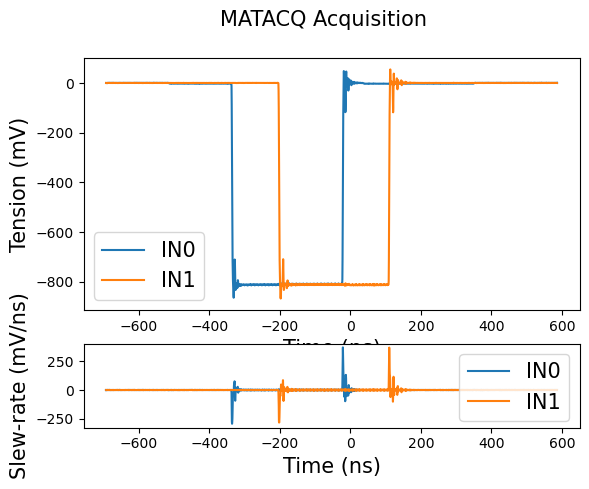

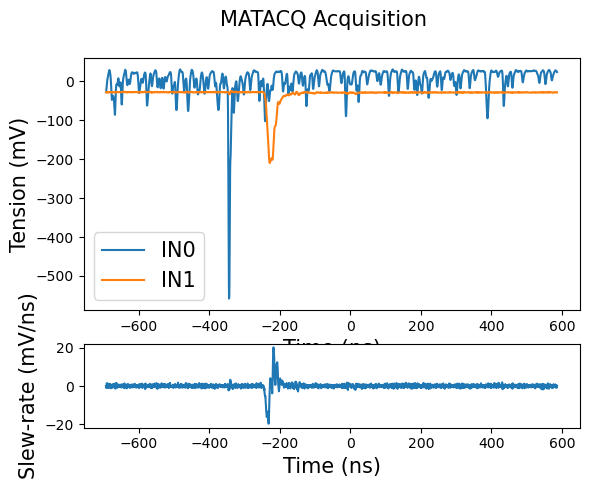

In [3]:
n_plot = 300
def plot_debug(n_plot):
    
    fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1]})
    fig.suptitle(
       "MATACQ Acquisition",
       fontsize=15,
    )
    
    
    ax1.plot(df_temp.iloc[2560*n_plot:2560*(n_plot+1),0],df_temp.iloc[2560*n_plot:2560*(n_plot+1),1],label='IN0')
    ax1.plot(df_temp.iloc[2560*n_plot:2560*(n_plot+1),2],df_temp.iloc[2560*n_plot:2560*(n_plot+1),3],label='IN1')
    
    ax1.set_xlabel("Time (ns)", fontsize=15)
    ax1.set_ylabel("Tension (mV)", fontsize=15)
    # ax1.set_ylim(0, 25)
    
    ax1.legend(fontsize=15)
    
    
    
    ax2.plot(df_temp.iloc[2560*n_plot:2560*(n_plot+1),0],df_temp.iloc[2560*n_plot:2560*(n_plot+1),8],label='IN0')
    ax2.plot(df_temp.iloc[2560*n_plot:2560*(n_plot+1),2],df_temp.iloc[2560*n_plot:2560*(n_plot+1),9],label='IN1')
    
    ax2.set_xlabel("Time (ns)", fontsize=15)
    ax2.set_ylabel("Slew-rate (mV/ns)", fontsize=15)
    # ax1.set_ylim(0, 25)
    
    ax2.legend(fontsize=15)
    
    # fig.tight_layout()
    fig.show()
    
    
def plot_debug2(n_plot):
    
    fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1]})
    fig.suptitle(
       "MATACQ Acquisition",
       fontsize=15,
    )
    
    
    ax1.plot(df_temp.iloc[2560*n_plot:2560*(n_plot+1),4],df_temp.iloc[2560*n_plot:2560*(n_plot+1),5],label='IN0')
    ax1.plot(df_temp.iloc[2560*n_plot:2560*(n_plot+1),6],df_temp.iloc[2560*n_plot:2560*(n_plot+1),7],label='IN1')
    
    ax1.set_xlabel("Time (ns)", fontsize=15)
    ax1.set_ylabel("Tension (mV)", fontsize=15)
    # ax1.set_ylim(0, 25)
    
    ax1.legend(fontsize=15)   
    
#     ax2.plot(df_temp.iloc[2560*n_plot:2560*(n_plot+1),0],df_temp.iloc[2560*n_plot:2560*(n_plot+1),10],label='IN0')
    ax2.plot(df_temp.iloc[2560*n_plot:2560*(n_plot+1),2],df_temp.iloc[2560*n_plot:2560*(n_plot+1),11],label='IN1')
    
    ax2.set_xlabel("Time (ns)", fontsize=15)
    ax2.set_ylabel("Slew-rate (mV/ns)", fontsize=15)
    # ax1.set_ylim(0, 25)
    
#     ax2.legend(fontsize=15)
    

plot_debug(n_plot)
#
plot_debug2(n_plot)
    

## Debug PSD

In [4]:
t_max = []
t_start = []
t_CFD_A3 = []
t_CFD_A4 = []
delai = []
A = []
offset = []
Ishort = []
Itot = []

T_short = 50
T_tot = 250 

for i in range(n):
    
    

    df0 = df_temp[2560*i:2560*(i+1)]

    t_max_temp = df0.at[df0["A4"].idxmin(),"t4"]
    t_max.append(t_max_temp)
    
    t_start_temp = df0[df0['d4'] < -5].iloc[0]["t4"] - 2
    t_start.append(t_start_temp)
    
    t_CFD_A3_temp = df0.at[df0["d1"].idxmin(),"t1"]
    t_CFD_A3.append(t_CFD_A3_temp)
    
    t_CFD_A4_temp = df0.at[df0["d2"].idxmin(),"t2"]
    t_CFD_A4.append(t_CFD_A4_temp)
    
    delai.append(t_CFD_A4_temp-t_CFD_A3_temp)
    
    df1=df0.to_numpy()
    mins = np.argmin(df1,axis=0)
    IDminA3 = mins[5]
    IDminA4 = mins[7]
    
    offset_temp = np.mean(df1[IDminA4-200:IDminA4-150,7])
    offset.append(offset_temp)
    
    A_temp = -min(df0["A4"]) + offset_temp
    A.append(A_temp)
    
    dft1 = -(df0[(df0['t4'] > t_start_temp + T_short) & (df0['t4'] < t_start_temp + T_tot ) ]["A4"] - offset_temp)
    
    
    Ishort_temp = dft1.sum()
    Ishort.append(Ishort_temp)


    dft2 = -(df0[(df0['t4'] > t_start_temp ) & (df0['t4'] < t_start_temp + T_tot) ]["A4"] - offset_temp)    
    
    Itot_temp = dft2.sum()
    Itot.append(Itot_temp)
    



    
    

    

In [5]:
PSD = np.array(Ishort)/np.array(Itot)

## Delai distribution

In [6]:
xr = (0, 0.3)
nbins = 100

def cdf(xe, z, mu1, sigma1, mu2, sigma2):
    return (z * truncnorm.cdf(xe, *xr, mu1, sigma1) +
            (1-z) * truncnorm.cdf(xe, *xr, mu2, sigma2))

hist, bins = np.histogram(PSD,range=[0,0.7],bins=100)

c = cost.BinnedNLL(hist, bins, cdf)
m = Minuit(c, z=0.6, mu1=0.1, mu2 = 0.2, sigma1=0.01, sigma2=0.01)
m.limits["z"] = (0, 1)
m.limits["sigma1","sigma2"] = (0, 0.1)
m.limits["mu1","mu2"] = (0.1, 0.5)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.546e+06 (χ²/ndof = 16278.7)│              Nfcn = 197              │
│ EDM = 1.75e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ z      │   0.657   │   0.004   │            │            │    0    │    1    │       │
│ 1 │ mu1    │ 113.22e-3 │  0.12e-3  │            │            │   0.1   │   0.5   │       │
│ 2 │ sigma1 │ 10.08e-3  │  0.09e-3  │            │            │    0    │   0.1   │       │
│ 3 │ mu2    │ 213.3e-3  │  0.4e-3   │            │            │   0.1   │   0.5   │       │
│ 4 │ sigma2 │ 23.98e-3  │  0.28e-3  │            │            │    0    │   0.1   │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────┐
│        │         z       mu1    sigma1       mu2    sigma2 │
├────────┼───────────────────────────────────────────────────┤
│      z │  1.85e-05  0.006e-6      7e-9   0.03e-6  -0.04e-6 │
│    mu1 │  0.006e-6  1.33e-08      0e-9  0.001e-6 -0.002e-6 │
│ sigma1 │      7e-9      0e-9  7.28e-09      1e-9     -2e-9 │
│    mu2 │   0.03e-6  0.001e-6      1e-9  1.43e-07  -0.01e-6 │
│ sigma2 │  -0.04e-6 -0.002e-6     -2e-9  -0.01e-6   8.1e-08 │
└────────┴───────────────────────────────────────────────────┘

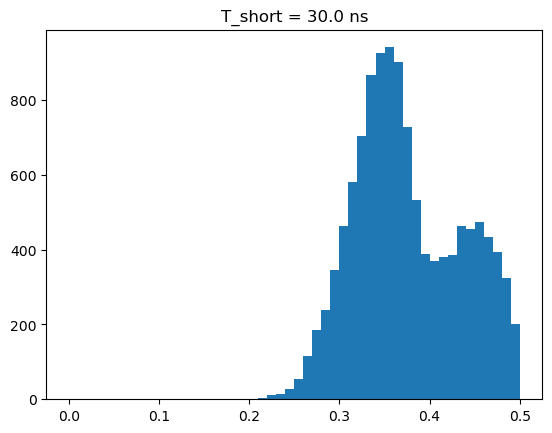

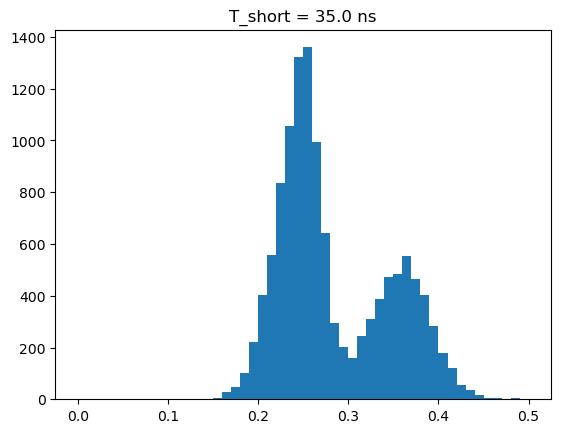

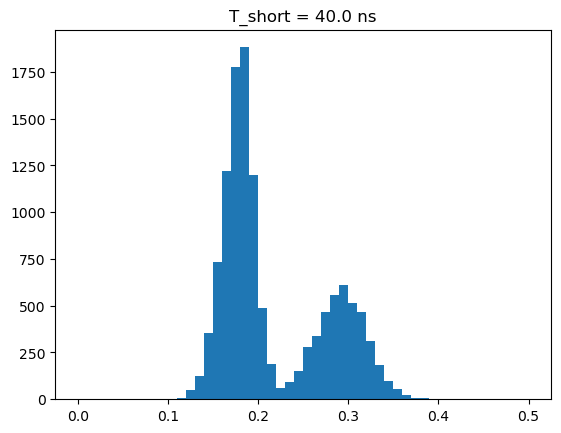

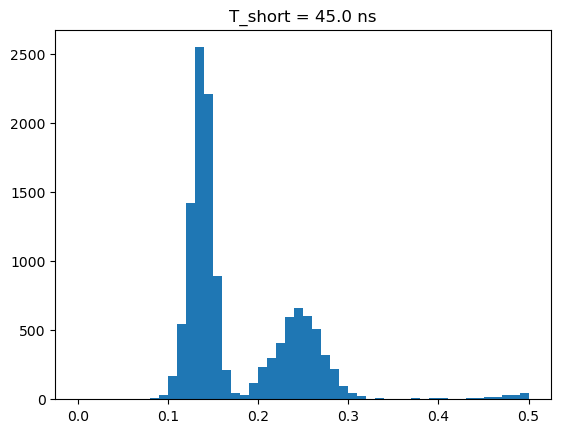

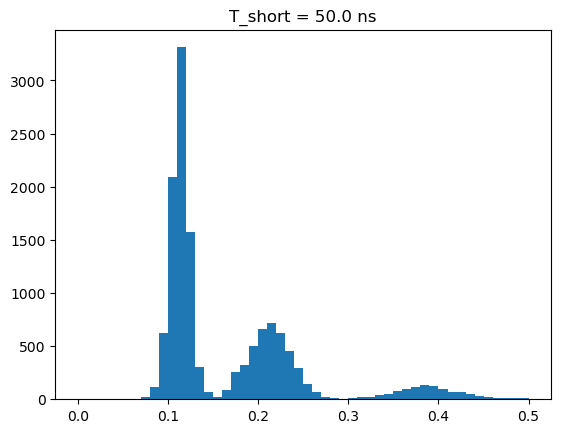

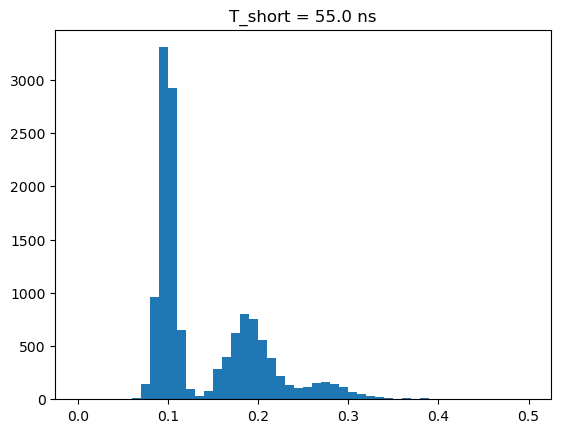

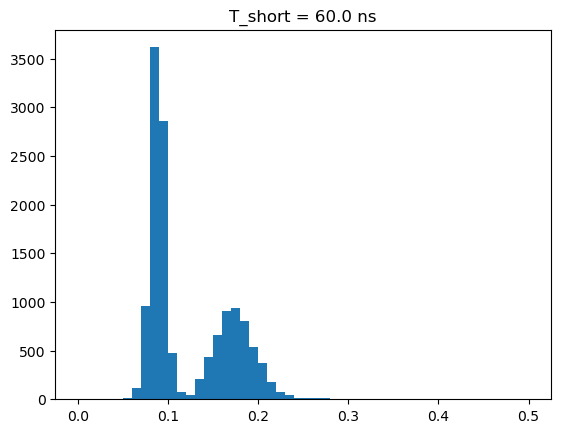

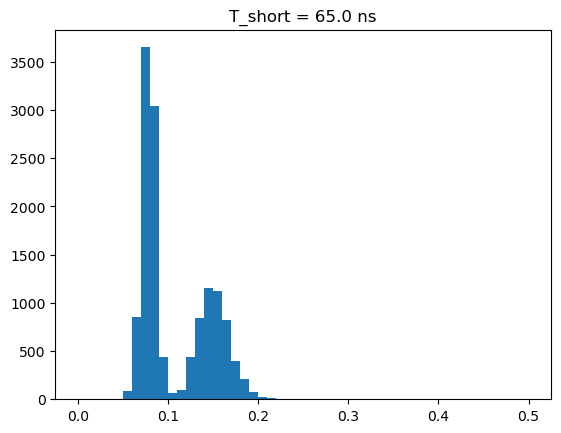

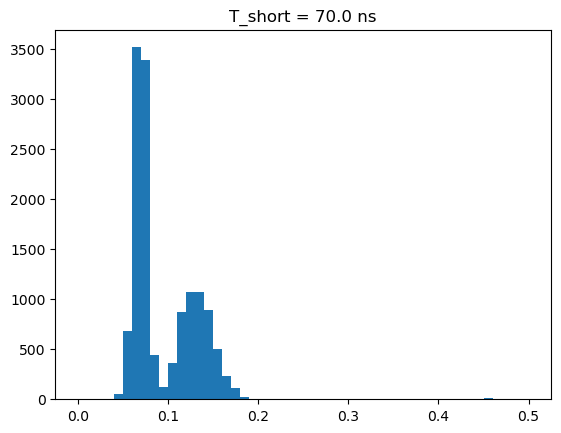

In [8]:
for j,T_short in enumerate(T_shorts) :
    plt.figure()
    plt.hist(var[:,j,2],bins=50,range=[0,0.5])
    plt.title(f"T_short = {T_short} ns")

AttributeError: module 'scipy' has no attribute 'signal'

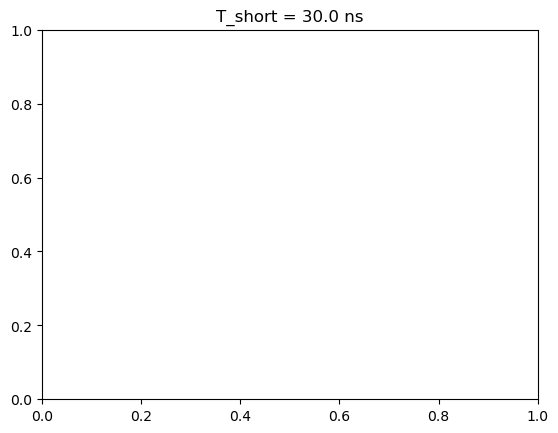

In [9]:
FoMs = []

for j,T_short in enumerate(T_shorts) :
    
    plt.title(f"T_short = {T_short} ns")
    
    if T_short>45:
        xr = (0, 0.3)
    else :
        xr = (0, 0.5)
    nbins = 100

    def cdf(xe, z, mu1, sigma1, mu2, sigma2):
        return (z * truncnorm.cdf(xe, *xr, mu1, sigma1) +
                (1-z) * truncnorm.cdf(xe, *xr, mu2, sigma2))

    hist, bins = np.histogram(var[:,j,2],range=[xr[0],xr[1]],bins=100)

    c = cost.BinnedNLL(hist, bins, cdf)
    
#     peaks,_  = scipy.signal.find_peaks(hist,distance=10,height=200)
#     peaks_pos = bins[peaks]
    
#     print(peaks_pos)
    
    m = Minuit(c, z=0.6, mu1=peaks_pos[0], mu2 = peaks_pos[1], sigma1=0.01, sigma2=0.01)
    m.limits["z"] = (0, 1)
    m.limits["sigma1","sigma2"] = (0, 0.1)
    m.limits["mu1","mu2"] = (0.1, 0.5)
    m.migrad()
    plt.figure()
    plt.title(f"T_short = {T_short} ns")
    m.visualize()
    fit_info = [
    f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {m.fmin.reduced_chi2:.1f}",
]
    for p, v, e in zip(m.parameters, m.values, m.errors):
        fit_info.append(f"{p} = ${v:.2f} \\pm {e:.2f}$")
    
    
    z,mu1,sigma1,mu2,sigma2 = m.values
    FoM = abs(mu2-mu1)/(sigma1+sigma2)
    
    
    fit_info.append(f"FoM = {FoM:.2f}")
    plt.legend(title="\n".join(fit_info))
    params.append(m.values)
    FoMs.append(FoM)

In [11]:
T_tot = 250 
n_val = 9
T_short = 54
PSDs =[]
As = []
print(f"Moulinette T_start = {T_short} ns")
for i in range(n):

    df0 = df_temp[2560*i:2560*(i+1)]

    t_CFD_A3_temp = df0.at[df0["d1"].idxmin(),"t1"]

    t_CFD_A4_temp = df0.at[df0["d2"].idxmin(),"t2"]

    t_start_temp = df0[df0['d4'] < -5].iloc[0]["t4"] - 2


    df1=df0.to_numpy()
    mins = np.argmin(df1,axis=0)
    IDminA3 = mins[5]
    IDminA4 = mins[7]



    offset_temp = np.mean(df1[IDminA4-200:IDminA4-150,7])





    A_temp = -min(df0["A4"]) + offset_temp
    As.append(A_temp)


    dft1 = -(df0[(df0['t4'] > t_start_temp + T_short) & (df0['t4'] < t_start_temp + T_tot ) ]["A4"] - offset_temp)


    Ishort_temp = dft1.sum()

    dft2 = -(df0[(df0['t4'] > t_start_temp ) & (df0['t4'] < t_start_temp + T_tot) ]["A4"] - offset_temp)    

    Itot_temp = dft2.sum()

    PSD = Ishort_temp/Itot_temp
    
    PSDs.append(PSD)


Moulinette T_start = 54 ns


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


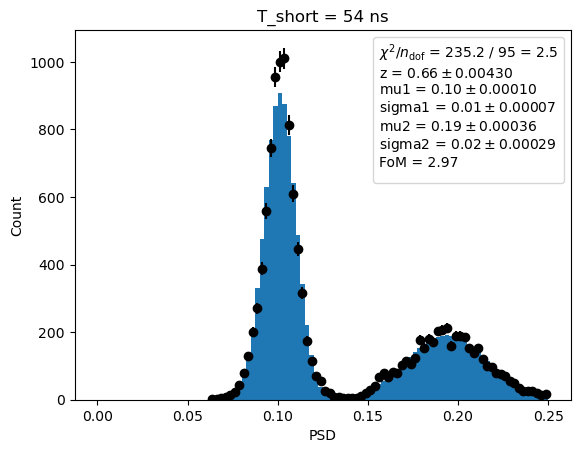

In [13]:


xr = (0.00, 0.25)
# plt.title(f"T_short = {T_short} ns")


nbins = 100

def cdf(xe, z, mu1, sigma1, mu2, sigma2):
    return (z * truncnorm.cdf(xe, *xr, mu1, sigma1) +
            (1-z) * truncnorm.cdf(xe, *xr, mu2, sigma2))

hist, bins = np.histogram(PSDs,range=[xr[0],xr[1]],bins=100)

c = cost.BinnedNLL(hist, bins, cdf)

# peaks,_  = scipy.signal.find_peaks(hist,distance=10,height=200)
# peaks_pos = bins[peaks]

# print(peaks_pos)

m = Minuit(c, z=0.6, mu1=0.08, mu2 =0.18, sigma1=0.01, sigma2=0.01)
m.limits["z"] = (0, 1)
m.limits["sigma1","sigma2"] = (0, 0.2)
m.limits["mu1","mu2"] = (0, 0.5)
m.migrad()
plt.figure()
plt.title(f"T_short = {T_short} ns")
m.visualize()
fit_info = [
f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {m.fmin.reduced_chi2:.1f}",
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.2f} \\pm {e:.5f}$")


z,mu1,sigma1,mu2,sigma2 = m.values
FoM = abs(mu2-mu1)/(sigma1+sigma2)


fit_info.append(f"FoM = {FoM:.2f}")
plt.legend(title="\n".join(fit_info))

plt.xlabel("PSD")
plt.ylabel("Count")

T_shorts = [30   ,38  ,   46 ,   54,  58,   62,   70,   78,   86]
chi2 =     [3.3  ,2.6 ,  2.8 ,  2.5, 2.6,  2.8,  2.8,  2.5,  2.9]
FoMs =     [1.55 ,2.34, 2.82, 2.97, 2.96, 2.99, 2.51, 2.21, 1.87]

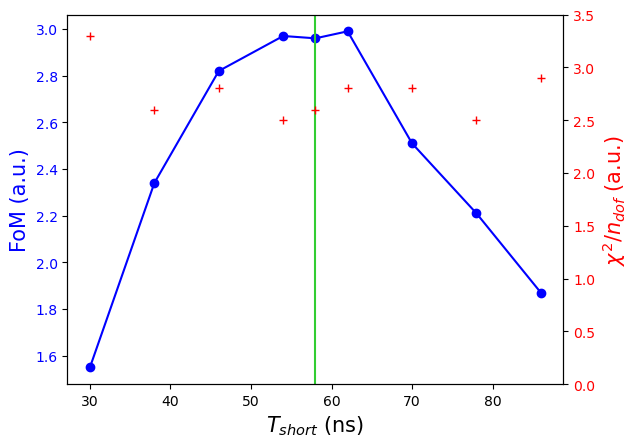

In [7]:
T_shorts = [30   ,38  ,   46 ,   54,  58,   62,   70,   78,   86]
chi2 =     [3.3  ,2.6 ,  2.8 ,  2.5, 2.6,  2.8,  2.8,  2.5,  2.9]
FoMs =     [1.55 ,2.34, 2.82, 2.97, 2.96, 2.99, 2.51, 2.21, 1.87]

fig, ax1 = plt.subplots()

ax1.plot(T_shorts,FoMs,"bo",label="FoM")
ax1.plot(T_shorts,FoMs,"b")
ax1.set_xlabel('$T_{short}$ (ns)',fontsize=15)
ax1.set_ylabel('FoM (a.u.)',color="blue",fontsize=15)
ax1.axvline(x=58,color="limegreen")
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(T_shorts,chi2,"r+",label="$\chi^{2}/n_{dof}$")
ax2.set_ylabel('$\chi^{2}/n_{dof}$ (a.u.)',color="red",fontsize=15)
ax2.set_ylim([0,3.5])
ax2.tick_params(axis='y', labelcolor='red')

In [ ]:
from scipy.signal import argrelextrema


argrelextrema(hist, np.greater)
hist

In [ ]:
peaks,_  = scipy.signal.find_peaks(hist,distance=10,height=200)
peaks_pos = bins(peaks)

In [ ]:
 plt.hist(var[:,0,2],bins=100)

In [ ]:
###################
#   2D PLOT 
###################

plt.title(
   "2D distribution",
   fontsize=15,
)

As = np.array(As) 
PSDs = np.array(PSDs)

plt.hist2d(As[As<900], PSDs[As<900], bins=100, range=[[0,1000],[0,0.3]])
plt.xlabel("Amplitude $Ne213$ (mV)", fontsize=15)
plt.ylabel("Tail integral/Total integral $Ne213$", fontsize=15)